# Digital Twin - Constant product AMM


In [159]:
import copy
import json
import math
import matplotlib.pyplot as plt

def init_genesis():
    return  {
        "AMM":{"r_1":100,"r_2":100,"s":100,"fee":0.00},
        "Trader":{"r_1":100,"r_2":100,"s":0},
        "LP":{"r_1":0,"r_2":0,"s":100}
    }

def swapToAsset1(state,inputs):
    agent = inputs[0]
    dA2 = inputs[1]
    feeFactor = (1-state["AMM"]["fee"])
    dA1 = state["AMM"]["r_1"]/(state["AMM"]["r_2"]+dA2*feeFactor)*dA2*feeFactor
    if dA2>0 and state[agent]["r_2"]-dA2 >= 0 :
        state["AMM"]["r_2"]+=dA2
        state[agent]["r_2"]-=dA2
        state["AMM"]["r_1"]-=dA1
        state[agent]["r_1"]+=dA1

def swapToAsset2(state,inputs):
    agent = inputs[0]
    dA1 = inputs[1]
    feeFactor = (1-state["AMM"]["fee"])
    dA2 = state["AMM"]["r_2"]/(state["AMM"]["r_1"]+dA1*feeFactor)*dA1*feeFactor
    if dA1>0 and state[agent]["r_1"]-dA1 >= 0 :
        state["AMM"]["r_1"]+=dA1
        state[agent]["r_1"]-=dA1
        state["AMM"]["r_2"]-=dA2
        state[agent]["r_2"]+=dA2

def addLiquidity(state,inputs):
    agent = inputs[0]
    R1=state["AMM"]["r_1"]
    R2=state["AMM"]["r_2"]
    S= state["AMM"]["s"]
    dA1=min(inputs[1],R1/R2*inputs[2])
    dA2=min(inputs[2],R2/R1*inputs[1])
    if (dA1 <= state[agent]["r_1"] and dA2 <= state[agent]["r_2"]) and (dA1 > 0 and dA2 > 0):
        state[agent]["r_1"]-=dA1
        state[agent]["r_2"]-=dA2
        state["AMM"]["r_1"]+=dA1
        state["AMM"]["r_2"]+=dA2
        dS = min(dA1/R1, dA2/R2) * S
        state["AMM"]["s"] += dS
        state[agent]["s"]+=dS

def removeLiquidity(state,inputs):
    dS = inputs[1]
    agent = inputs[0]
    if dS > 0 and state[agent]["s"]-dS>=0 and state["AMM"]["s"]-dS>=0:
        DR = (1-dS/state["AMM"]["s"])
        R1=state["AMM"]["r_1"]
        R2=state["AMM"]["r_2"]
        state[agent]["s"]-=dS
        state["AMM"]["r_1"]=R1*DR
        state["AMM"]["r_2"]=R2*DR
        state[agent]["r_1"]+=R1-state["AMM"]["r_1"]
        state[agent]["r_2"]+=R2-state["AMM"]["r_2"]
        state["AMM"]["s"]-=dS

def pretty_print(obj):
    print(json.dumps(obj, sort_keys=True, indent=4))

def nice_print(self):
    if type(self)==float:
        return  round(self,3)
    if type(self)==int:
        return  self
    if type(self)==list:
        return  list(map(lambda l: print(l),self))
    if type(self)==dict:
        return  dict(map(lambda kv: (kv[0], print(kv[1])),self.items()))

def evolve(state, actionStack):
    history = [copy.deepcopy(state)]
    for action in actionStack:
        action[0](state,action[1])
        history.append(copy.deepcopy(state))
    return history 

### Testing the swapToAsset2 function

We create a genesis state with:

- the AMM having 100 Token 1, 100 Token 2, 100 pool shares, and a fee of 0.0
- the Trader having 100 Token 1, 100 Token 2, and no pool shares
- the Liquidity Provider has 0 Token 1, 0 Token 2, and 100 pool shares
Then we apply the swapToAsset2 function and look at the new genesis state by typing genesis

which will print the values of the variables to the screen. 

In [160]:
# test 1
state = init_genesis()
swapToAsset2(state,["Trader",10])
pretty_print(state)

{
    "AMM": {
        "fee": 0.0,
        "r_1": 110,
        "r_2": 90.9090909090909,
        "s": 100
    },
    "LP": {
        "r_1": 0,
        "r_2": 0,
        "s": 100
    },
    "Trader": {
        "r_1": 90,
        "r_2": 109.0909090909091,
        "s": 0
    }
}


Lets now take a look at a more elaborate state transition and perform two different swaps after one another: we append exactly the swap in opposite direction expecting that this restores the state.

In [161]:
state = init_genesis()

swapToAsset2(state,["Trader",10])
swapToAsset1(state,["Trader",9.0909090909091])

pretty_print(state)

{
    "AMM": {
        "fee": 0.0,
        "r_1": 99.99999999999999,
        "r_2": 100.0,
        "s": 100
    },
    "LP": {
        "r_1": 0,
        "r_2": 0,
        "s": 100
    },
    "Trader": {
        "r_1": 100.00000000000001,
        "r_2": 100.0,
        "s": 0
    }
}


Create an actionList that represents the following actions (in this order):

1. The trader puts 50 Asset 1 to the AMM, in exchange for Asset 2

2. The trader deposits 25 Asset 2 to the AMM, in exchange for Asset 1

How much of Asset 1 does the trader have at this point? Might this surprise the Trader? 

In [162]:
# test 3
state = init_genesis()
actionList = [
        [ swapToAsset1 ,  ["Trader", 50.0] ],
        [ swapToAsset2 ,  ["Trader", 25.0] ]
]
evolve(state, actionList)
#pretty_print(genesis)

# How much of Asset 1 does the trader have at this point? Might this surprise the Trader?  
state["Trader"]["r_1"]

108.33333333333331

### Try Another One

As the code is currently written, it would be possible for a careless user to input a genesis block that contained) invalid information (such as a negative value for the tokens). Write a function called check_genesis_block that returns True if all inputs to the genesis block are valid, and False if there are invalid inputs. 

You can check that your function works as intended by creating three examples that are invalid in some way, and being sure that your function 

In [163]:
def check_genesis_block(state):
    return state["AMM"]["r_1"] >= 0 and \
        state["AMM"]["r_2"] >= 0 and \
        state["AMM"]["s"] >= 0 and \
        state["AMM"]["fee"] >= 0 and \
        state["Trader"]["r_1"] >= 0 and \
        state["Trader"]["r_2"] >= 0 and \
        state["Trader"]["s"] >= 0 and \
        state["LP"]["r_1"] >= 0 and \
        state["LP"]["r_2"] >= 0 and \
        state["LP"]["s"] >= 0

state = init_genesis()
print(check_genesis_block(state))

True


### Updating Pool Fees

In this section, we have assumed that the fees for the liquidity pool remain the same as time goes on. Write a function called update_pool_fees that changes the fee charged by the AMM, so we may adjust that in our simulation.

In [164]:
def update_pool_fees(state, new_fee):
    state["AMM"]["fee"] = new_fee

state = init_genesis()
update_pool_fees(state, 0.3)
print(state)

{'AMM': {'r_1': 100, 'r_2': 100, 's': 100, 'fee': 0.3}, 'Trader': {'r_1': 100, 'r_2': 100, 's': 0}, 'LP': {'r_1': 0, 'r_2': 0, 's': 100}}


### Trading a Percentage of the Wallet

In this section, we have assumed that the user wanted to swap a particular amount of tokens. What if instead we want the user to be able to swap a certain percentage of their holdings?

 Write a function called swapToAsset2_pct that swaps a certain percentage of the user's Asset 1 funds in exchange for Asset 2 

(Hint: Write a helper function called pctToAmount that converts percent to amount, and then can call the swapToAsset2 function.

In [165]:
def pctToAmount(state, pct):
    if pct > 100:
        pct = 100
    elif pct < 0:
        pct = 0

    pct = pct / 100
    return state["Trader"]["r_1"]*pct

def swapToAsset2_pct(state, inputs):
    inputs[1] = pctToAmount(state, inputs[1])
    return swapToAsset2(state, inputs)

genesis = init_genesis()
swapToAsset2_pct(genesis, ["Trader", 3])
print(genesis)


{'AMM': {'r_1': 103.0, 'r_2': 97.0873786407767, 's': 100, 'fee': 0.0}, 'Trader': {'r_1': 97.0, 'r_2': 102.9126213592233, 's': 0}, 'LP': {'r_1': 0, 'r_2': 0, 's': 100}}


### Pretty Print in Fiat Values

In this section, we have been completely agnostic as to the underlying value that a user's token holding may have in terms of a reference currency such as USD or EURO. Write a function fiat_print_holdings that takes in the names and prices of the tokens as a dictionary, then gives the value of the user's portfolio in the reference currency.

In [166]:
def fiat_print_holdings(state, agent, token_1, token_2, ref_currency):
    token_1_amount = state[agent][token_1["name"]]*token_1["price"]
    token_2_amount = state[agent][token_2["name"]]*token_2["price"]
    return  token_1_amount + token_2_amount

state = init_genesis()
token_1 = {"name": "r_1", "price": 5}
token_2 = {"name":"r_2", "price": 3}
fiat_print_holdings(state, "Trader", token_1, token_2 , "USD") 

800

Since the trader has holdings equivalent to 800 USD. 
This allows us to simulate impermanent loss by considering the fact that the value of the assets the trader holds may change.

### Verifying the Digital Twin

To trust the results of the digital twin, we need to be completely sure that it captures the behavior of the system we designed. 

Looking at our finished digital Twin, we want to be sure: does it really behave as it is meant to? This needs to be verified. To do so, we create simple test scenarios through which our simulations can run. These scenarios should be simple enough that we can verify them by hand. Let us recall what we expect from a well-coded digital Twin according to the business requirements:

**During a swap action,**
- the invariant shall remain unchanged (assuming no fees)
- the total number of tokens of Asset 1 in the system shall be unchanged
- the total number of tokens of Asset 2 in the system shall be unchanged
- given a specific amount of one Asset the correct amount of the other Asset shall be returned.

**During a liquidity removal**
- the total number of tokens of Asset 1 shall be unchanged,
- the total number of tokens of Asset 2 shall be unchanged,
- the correct number of shares shall be taken and burned,
- the correct amount of each Asset shall be transferred.

**During a liquidity insertion**
- the total number of tokens of Asset 1 shall be unchanged,
- the total number of tokens of Asset 2 shall be unchanged,
- the correct number of shares shall be minted and distributed,
the correct amount of each Asset shall be transferred.

For each of these requirements we need to think about good test scenarios that our digital Twin can simulate. Looking at the list above we see that the some of the actions have requirements in common.

Checking that the invariant is preserved during swap actions requires a calculation of the invariant for a given state. 
The conservation of tokens can be easily checked by counting them. 

Let's define three helpful functions:
- invariant
- asset1
- asset2

In [167]:
# it returns k, the invariant of the AMM 
def invariant(state):
    return state["AMM"]["r_1"] * state["AMM"]["r_2"]

def asset(state, asset_key):
    sum = 0
    for key in state:
        sum += state[key][asset_key]
    return sum

# how many asset1 do we have in the state
def asset1(state):
    return asset(state, "r_1")

# how many asset2 do we have in the state
def asset2(state):
    return asset(state, "r_2")

First, let's use the invariant function to see if things work as intended. 

In [168]:
genesis = init_genesis()

state = copy.deepcopy(genesis)

swapToAsset2(state,["Trader",13])

invariant(genesis)==invariant(state)

True

### Verifying the System (and the Test) 

That is, we just create a genesis state which is then copied into the variable state that evolves through the swap action. In the last line we just check whether or not the invariance is identical for genesis state and evolved state. As can be expected, this test returns True. The same test can be performed for a swap in opposite direction. 

Keep in mind that the invariant is only preserved as long as there are no fees. Knowing scenarios in which the tests fail is important to verify also that the test in fact can fail: whenever possible, test the test!

You Try It: Verify that the test for preserved liquidity fails if nonzero fees are set.

In [169]:
genesis = init_genesis()

state = copy.deepcopy(genesis)

update_pool_fees(state, 0.3)

swapToAsset2(state,["Trader",13])

invariant(genesis)==invariant(state)

False

Now let's look at conservation of number of tokens in the system. 

In [170]:
state = init_genesis()

swapToAsset1(state,["Trader",13])

asset1(genesis)==asset1(state) and asset2(genesis)==asset2(state)

True

### Testing Individually or In Tandem

In the code block above, we combined the test for the asset1 and asset2 function. 

If we repeat the test for every state transition function we have coded, we can verify token conservation individually. We can also make sure this test will fail when appropriate by providing manipulated states:

In [171]:
genesis = {
    "AMM":{"r_1":100,"r_2":100,"s":100,"fee":0.0},
    "Trader":{"r_1":100,"r_2":100,"s":0},
    "Liquidator":{"r_1":0,"r_2":0,"s":100}
    }

state = {
    "AMM":{"r_1":100,"r_2":100,"s":100,"fee":0.0},
    "Trader":{"r_1":0,"r_2":100,"s":0},
    "Liquidator":{"r_1":0,"r_2":0,"s":100}
    }
    
asset1(genesis)==asset1(state) and asset2(genesis)==asset2(state)

False

### Providing Something Broken (on Purpose)

Instead of transitioning from the genesis to the next by usage of our state transition function, we just provide the next state by hand. Observe that we have taken away all of Asset 1 from the Trader (Quite sure, he won't like that...). Now the test returns False , as expected. Now we can work on further tests.

If you are doing the tests right, you usually produce far more source code for the tests than for the twin you are testing. It can easily be the case that the tests are twice as big as the system to be tested; even tests ten times bigger than the system of interest are nothing to worry about. Do not be greedy with your time when testing your system and try to think about as many test scenarios as possible! 

We need to think about how the system should behave in more complex scenarios and which additional properties we can derive from that. One often important thing is reversibility: as long as the invariant is preserved, there should be an inverse action to every state transition. For a swap to Asset 1 the inverse is given by those swap to Asset 2 that exchanges exactly the return of the previous swap:

In [172]:
genesis = {
    "AMM":{"r_1":100,"r_2":100,"s":100,"fee":0.0},
    "Trader":{"r_1":100,"r_2":100,"s":0},
    "Liquidator":{"r_1":0,"r_2":0,"s":100}
}

state = copy.deepcopy(genesis)

swapToAsset1(state,["Trader",13])

gained = state["Trader"]["r_1"] - genesis["Trader"]["r_1"]

swapToAsset2(state,["Trader",gained])

genesis == state

True

### Looking at the Function

**What is Happening?**

Until  the variable gained is defined, everything should be familiar to you, but what are we doing with this variable gained?

We just determine how much of asset 1 the Trader obtained during their swap. This is done by calculating the differences of their possessions of asset 1 from genesis state to the state after the swap. This "gain" from the swap is stored in the variable gained so that it can be used later.

### Swappping Back
```
swapToAsset2(state,["Trader",gained])
```
On line 13 we perform a swap back to Asset 2, giving exactly the amount to the AMM that was gained in the previous swap. This should restore the state after this swap to the genesis state, which can be directly verified by checking whether the last state is identical to the genesis state in the last line.

### Checking for Equivalence
```
genesis == state
```
Here we are  directly verifying  that the last state is identical to the genesis state in the last line.

**You Try It:**

Write a similar test for the liquidity systems that verifies that a genesis state is reproduced after inserting liquidity and removing it again.



In [173]:
genesis = init_genesis()

state = copy.deepcopy(genesis)

addLiquidity(state, ["Trader", 5, 5])

removeLiquidity(state, ["Trader", 5, 5])

genesis == state

True

### Multiple Swap actions

Now let us take a look writing the system to implement multiple swap actions. 

Text(0, 0.5, 'Asset 2')

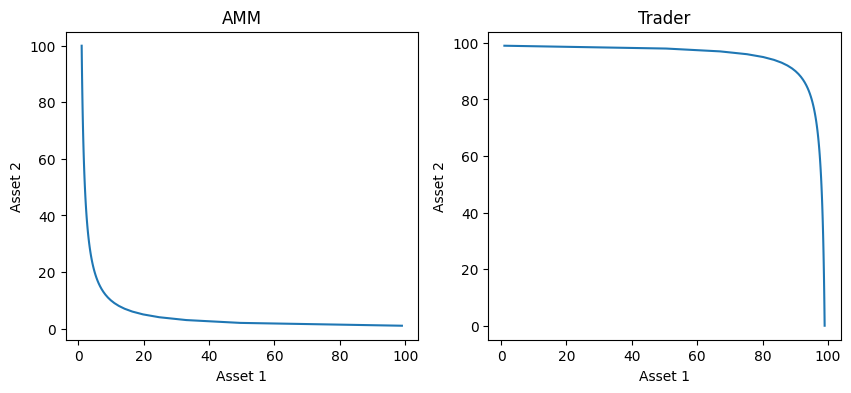

In [174]:
genesis = {
    "AMM":{"r_1":99,"r_2":1,"s":math.sqrt(99),"fee":0.0},
    "Trader":{"r_1":1,"r_2":99,"s":0},
    "Liquidator":{"r_1":200,"r_2":200,"s":100}
    }

actionList= [ [swapToAsset1,["Trader",1]] ] * 99

history = evolve(genesis, actionList)

AMM_r1=[]
Trader_r1=[]
AMM_r2=[]
Trader_r2=[]
for s in history:
    AMM_r1.append(s["AMM"]["r_1"])
    Trader_r1.append(s["Trader"]["r_1"])
    AMM_r2.append(s["AMM"]["r_2"])
    Trader_r2.append(s["Trader"]["r_2"])   


plt.figure(figsize=(10,4)) 
    
plt.subplot(1, 2, 1) 
plt.plot(AMM_r1,AMM_r2)
plt.title('AMM')
plt.xlabel("Asset 1")
plt.ylabel("Asset 2")

plt.subplot(1, 2, 2)
plt.plot(Trader_r1,Trader_r2)
plt.title('Trader')
plt.xlabel("Asset 1")
plt.ylabel("Asset 2")

### Let's explain some parts of this code 

Notice that we are  starting from a different genesis state. Then we create a variable actionList as a repetition  99 times of a swap to asset 1. This is a very Python-specific construction, using the multiplication operator * on a list creates multiple repetitions of the original list. 

You may have already spotted the word "plot" within the code and guessed that we want to plot something. Yes, we want to create Figures now. To do so, we need to collect the data that we want to plot and rewrite it in a format that can be used by the matplotlib package of python. To store this data in the right form, we define new variables AMM_r1, Trader_r1, AMM_r2, Trader_r2. Then, we just grab one state after another from the history in the for loop and append the respective data to the corresponding variables.

Once, the data to be plotted is prepared, we make use of python's plotting functionalities. We want to plot two Figures beside one another. Hence, we need to ensure that the two Figures have enough space. This is done in the command plt.figure(figsize=(10,4)) where we tell Python the width and height of the total graphic.

In the remaining code, we perform a similar process twice.  we first use the command subplot to tell python that what comes after is to be placed in the first row (consisting of 2 columns) in the first, respective second column. Then, within the command plot we tell Python what needs to be plotted. The first parameter corresponds to the x-values of the points to be drawn, the second parameter to the y-values of the points. Last but not least, each plot gets a nice title and axes labels so that we know what it shows. The result is to be seen in the figure below. 

The plots show the simulated data generated by our code, showing how a large number of swaps changes the overall relationship between Asset 1 and Asset 2 for both the Trader and the AMM. 

Does this look familiar? Yes, we've seen it before. The graph of the AMM shown here corresponds exactly to the preserved invariant: along this curve the constant product is, well, constant.

**Now let's look at how the situation changes with a liquidity insertion. We execute the following code:**


Text(0, 0.5, 'Asset 2')

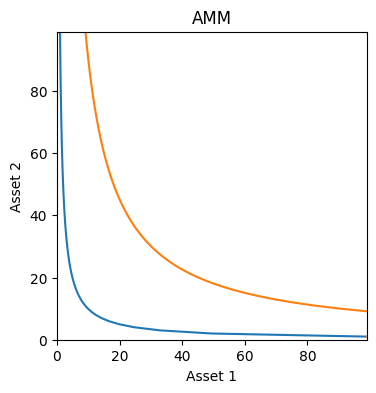

In [176]:
actionList.insert(0,[addLiquidity,["LP",100,100]])

genesis = {
    "AMM":{"r_1":99,"r_2":1,"s":math.sqrt(99),"fee":0.0},
    "Trader":{"r_1":1,"r_2":99,"s":0},
    "LP":{"r_1":200,"r_2":200,"s":100}
    }

history = evolve(genesis, actionList)

AMM_2r1=[]
Trader_2r1=[]
AMM_2r2=[]
Trader_2r2=[]
for s in history:
    AMM_2r1.append(s["AMM"]["r_1"])
    Trader_2r1.append(s["Trader"]["r_1"])
    AMM_2r2.append(s["AMM"]["r_2"])
    Trader_2r2.append(s["Trader"]["r_2"])   
    
plt.figure(figsize=(4,4)) 
plt.plot(AMM_r1,AMM_r2)
plt.plot(AMM_2r1,AMM_2r2)
plt.title('AMM')
plt.xlim([0, 99])
plt.ylim([0, 99])
plt.xlabel("Asset 1")
plt.ylabel("Asset 2")

Performing the simulated Liquidity Insertion event creates a new orange curve with an increased invariant. 

As it should be, our Python-based twin reproduces the Figures that we already expect from the mathematical formulation.

Now that we have verified the performance of our Digital Twin matches what we expected from the mathematical formalism in the Design Phase, we can move on to using it to explore the performance in the system.

We will do that in the next section.

## Simulation Experiments and Procedures

Now that we have verified the performance of our Digital Twin matches what we expected from the mathematical formalism in the Design Phase, we can move on to using it to explore the performance in the system.

We will do that in the next section. 

### The Process and Value of Simulation

For larger systems, the verification we just described will definitely not be achieved in the first iteration: you and others will make mistakes. This is no problem, as long as you identify and correct them during the verification procedure. Indeed, this is exactly the reason why we have such a  procedure at all! It will also happen that during verification you realize mistakes in the mathematical design and have to re-design parts of your system. As we have mentioned, Token Engineering is an iterative process.

Once the verification is done, the simulation starts. We want to examine the behavior of our system in a more natural environment to see how well the business requirements are fulfilled and what can be optimized. This ``more natural environment'' needs to become part of our simulation Behavioral science and game theory are the tools of choice: they allow to emulate the behavior of system participants by formally describing their strategies so that the different roles can be brought to life. 

Once, our simulation encompasses system participants behavior, we can look at how well the overall system behaves in different scenarios. What ``well-behaved'' means in this instance needs to be precisely quantified, which leads to the design of discovery indicators and metrics. 

Once we know the indicators and metrics, we have a kind of ``health bar'' for our system. Our Uniswap system has exactly one knob we can turn to optimize its health: the fee. More complicated systems can have more knobs to turn (along with other controls like buttons to press, levers to pull, people to scream at,  etc.) . Each of these knobs and buttons controls a parameter that influences one or more performance indicator or metrics. How to turn the knobs and press the buttons so that optimal health is achieved? 

This question can be answered by optimization procedures for the system's parameters. Also, we have to account for the unpredictable behaviour of the system participants. The so called Monte Carlo algorithms allow us to introduce randomness. We need to check whether or not our system stays healthy if irrational or even malicious agents participate.

## Performance Indicators and Metrics

Ultimately, we use performance indicators and metrics to assess the performance of our system. 

A Digital Twin is like a "what if?" machine: Simulation through a digital twin allows us to predict the performance on these metrics in various scenarios.

For our simple Uniswap we already identified two performance indicators: 
Slippage and Impermanent Loss. 
Before we look for more indicators and metrics, let us take a closer look at these two:

### Review of Slippage and Impermanent Loss

Slippage is the discrepancy between the theoretical return of a trade as expected from the spot price vs. the real returns once the trade is performed. They are not the same. The price you see is not the price you get. Traders do not like this. The more liquidity there is in the pool, the less the slippage is, and the happier the traders will be. 

Impermanent Loss is the discrepancy between holding your assets in a wallet versus providing them as liquidity to a pool. If the prices move, the liquidity provider would have been better off not providing liquidity. Liquidity providers do not like this. To encourage liquidity providers, we introduce a swap fee that reduces Impermanent Loss. However, this fee increases the discrepancy between the price the trader sees and the price of the actual trade. 

Within our digital Twin, we can measure the Impermanent Loss by comparing the assets in the present state of the liquidity providers to the genesis state throughout the simulation: the liquidity provider's happiness will be determined by whether or not their trades make money. 

There is a tradeoff between Slippage and Impermanent Loss, since decreasing slippage will increase Impermanent Loss, and vice versa. We can not optimize for both, so we must find a compromise. This is often the case with performance indicators: there is no global best, but only the choice of different compromises.

 We want a system that at least allows for the best possible compromise there is. This best possible compromise is the optimum we strive for. However, for slippage and Impermanent Loss in our simple Uniswap, it depends on the activity of traders and liqudiity providers, which in turn depends on the environment for our market. 

We have one parameter that we can set to aim for the optimum: the fee. But in more complex systems, there can be many more parameters that all have different influence on the system's performance, and we will be dealing with more than just two two indicators of slippage and Impermanent Loss. 

**Market Capitalization**

*This is strongly related to the liquidity within our pool, i.e. the value of the constant product for our Uniswap case. Usually we want market capitalization to be as large as possible: a market likes liquidity.*

**Volume**

*Usually volume is measured throughout an interval of 24 hours and also denoted as 24h-volume. It tells how much value "flowed" through the market due to swaps and can be calculated by nominating all swaps in same currency and adding up all swaps that occurred withing the respective time interval. Volume is crucial for the market to acquire information about prices. Volume is also what generates fees and ensures profit (or at least prevents losses) for the liquidity providers.*

### Creating new metrics from existing metrics

We now have four performance indicators, and each one will be its own variable to track. Watching four numbers is not easy, so we should invest some time to think about possibilities to make our "health bar" a bit simpler. 

Let us take these indicators and combine them so that we only need to watch a single number. This single number, the "health bar", is our metric. However, there are many ways that these numbers can be combined. 

Optimizing for the aforementioned indicators is similar to:

- Minimization of `(Slippage * IL)/(Liquidity * Volume)`, or 
- Minimization of `Slippage + IL- Liquidity - Volume`, or 
- Minimization of any function that increases as Slippage and IL increase, and decreases as Liquidity and Volume decrease.

Also, if we combine the above metrics, we get a new metric! There are many possibilities for such combination metrics, and each has its own system-specific advantages and disadvantages. Whatever we chose as metric, let us denote it as:
```
m(fee,...)
```
a function that takes in the fee and additional parameters. The value of these parameters is usually restricted by the business requirements and the system mechanics, as well as external circumstances. These restrictions can change. 

Optimizing the system is nothing more than the hunt for the best possible choice of parameter settings according to the current restrictions. 

By setting up measurements for the system inside a function, we can use both mathematical optimization techniques and simulations to explore the system's likely behavior. 

## Using Game Theory and Behavioral Economics

Now that we have a basic model of the market, we can make it more realistic by examining external factors that affect market dynamics. 

### Determining New Aspects of the System

Simulating an isolated system is as boring as it is useless. Based on some concepts taken from behavioral science, game theory and even thermodynamics, we could end this isolation. We want to describe the system interacting with its environment.

The simplest environment we can create consists just of some copies of our present AMM: just copy the respective token state and the transition functions and enumerate everything. Now we have not just one AMM, but a whole crowd of them. 

Alternatively or in addition, one can introduce an external market resembling a centralized exchange with infinite liquidity. This approach resembles the "mean field approximation" used in physics. By modifying the prices of the external market, we can simulate how our market behaves in the presence of perturbations like sudden price movements.

There it is, the environment, but what about the interactions?

### Looking at interactions

Interaction between markets is carried by the market participants. They have to be described from a behavioral or game theoretic perspective. This is done by defining strategies or roles that can be "played" by the system participants:

### Arbitrageurs

Consider for example an Arbitrageur, a trader who aims for profit by comparing the prices of multiple markets. 

His strategy is quite simple: If he sees the possibility to buy something at a low price price and directly sell it at higher price at a different market, he will do so. In his doing he conveys token transfers between the respective markets until price alignment occurs. 

Arbitrageurs are usually the fastest traders (mainly, because they are machines "living" onchain rather than humans living offchain).

### Speculators

Then there is a more speculative trader who tries to predict the price movement. He buys what he expects to rise in price and sells what he expects to fall in price. Let us call him "speculator". With him, all the traditional investment strategies are to be placed: chart analysis, fundamental analysis and whatever. Implementing all these different investment strategies in or simulations would be a huge task. 

We definitely need simplifications since our real task is not to predict losses or profit of all single traders, but to keep an eye on our market only. The previously mentioned mean field approximation  can lead the way: instead of describing many single traders, we may try to simulate the cumulative effect they have on our market. We can try to simulate this effect by defining the speculative strategy as follows: A speculator buys when a previously constant or falling price starts to rise and he sells when a previously rising price starts to fall.

### The Trader

In addition to these strategies we can expect that some trades are not striving directly for profit but are motivated by the need to obtain a specific currency due to whatever reason. This could be simulated by implementing swaps between random assets at the respective market that gives the best price.

### The Irrational

Irrational behavior can be taken into account by implementing random swaps without any restriction concerning price.

**How to Continue**

From here on we have many different possibilities how to continue. 

### One Strategy Each

Create for each of these strategies exactly one agent and analyse their profit-chances by collecting statistics about when and how much profit each of these agents makes during simulations. To do so, one would prepare a lot of different genesis states that define specific scenarios and run simulations until sufficient data is collected.

### Dynamic Choices of Strategies

Create an arbitrary number of agents but let each of them chose strategy dynamically: after specific random time steps, the agent takes a look at the history and changes his strategy to those that resulted in the most profit. This approach allows to look for so called Nash equilibria, that is, a stable evolution of the system in which no agent sees the need to change strategy. The presence or absence of such equilibria can be of great importance for the health of our system.

## Looking at Analytics from Simulation

When performing simulations, one should think in advance about what, how and why to analyze. Without defining this in advance it can happen that the wrong data is collected. Let us collect some usual research questions one should or could strive to find an answer to:

- Are there scenarios in which specific properties, variables, parameters, indicators or metrics start to grow exponentially or vanish? If so: Is this wanted or problematic?
- Are there oscillations of properties, variables, parameters, indicators or metrics observable? If so, are they of exploding, sustained or dampened nature? Do they pose a danger?
- Are there any Nash equilibria that correspond to an unhealthy system?

During the search for answers to these questions, one is advised to analyze each unwanted scenario as well as possible. The aim is, to identify specific metrics that identify such bad scenarios; for instance, we might design a metric that returns a high value in bad scenarios and a low value in good scenarios. Once such metrics are identified, we can strive for an optimization of the system's parameter selection procedures.

Once the appropriate metrics are identified, we can strive for an optimization of the system's parameter selection procedures.

Now we turn our attention to the tools for optimizing these procedures. 

## Optimization Techniques

Given a metric `m(f)` that depends on the single parameter f (e.g. the fee), how do we find those value for f that minimizes the metric m? Assume that f has to be between 0.01 and 0.1 (corresponding to a fee of 1% and 10% respectively).

One possibility is just given by brute force, or strategic trial and error: run simulations for different choices, determine the value of the metric and after the fee has run from $0.01$ to $0.1$ just select those value that resulted in the lowest metric. Such an approach is also called a Parameter Sweep; it is commonly used in cadCAD. It has the advantage that it is relatively simple to implement, but can require a  lot of computational resources since you are running the simulation multiple times. 

An alternative, a bit more elaborate possibilities is based on a so called gradient climb. Instead of performing the trial and error throughout the whole interval our parameters is restricted to, we just take the present value f for the parameter, chose an arbitrary stepwidth s and perform these steps:

1. If `m(f-s)` is lower than `m(f)`, we chose `f-s` as our new value for the parameter.
2. If `m(f+s)` is lower than `m(f)`, we chose `f+s` as our new value for the parameters.
3. Should neither of the two be the case, we reduce the stepwidth s and try again.
4. With this new value of `f` we just repeat the procedure until the stepwidth `s` has become small enough.

If we are seeking to minimize a function, the way that these values progress according to this algorithm is similar to a ball rolling down a hill. 

There are even more elaborate methods like `simulated annealing` or `"swarm-based algorithms"`, to mention some. There is an immense toolkit of ways to optimize a mathematical function, many of which are in existing Python libraries. This is one place where mathematics and computation are very important for a Token Engineer to know. 

## Conclusion and next steps

We have discussed basic techniques for translating mathematical formulas describing the system into code that enables simulation of the system.

## Other Software Tools for Token Engineering

In the previous section, we implemented a simulation model in base Python. Python is a popular language for getting started, as it blends power and simplicity very well. 

There are other tools that are often used in the Token Engineering community. We encourage you to explore these on your own, as there are multiple resources available. 

- [cadCAD](http://cadcad.org/). cadCAD is a simulation tool for complex adaptive systems, of which cryptoeconomic systems are one type. It has been used in the modeling and simulation of a number of token projects, including [RAI](https://medium.com/tokenengineering/rai-workshops-modeling-the-money-god-9626cc883a5). You can learn more about the tool (including beginner-friendly tutorial courses) at [cadcad.org](https://cadcad.org/).
- [TokenSPICE](https://github.com/tokenspice/tokenspice). TokenSPICE is an agent-based simulation engine based on the Ethereum Virtual Machine. It differs from cadCAD in its specific focus on tokenomics at the level of the token address. Find more information on [GitHub](https://github.com/tokenspice/tokenspice) or [Twitter](https://github.com/tokenspice/tokenspice).
- [Machinations](https://machinations.io/). A graphical tool that makes it possible to simulate systems without writing code (though it is possible to add code that extends functionality). Machinations is already popular for modeling digital game economies. Find out more information at [the official webpage](https://machinations.io/).